## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering


February 9th, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Image Restoration and Reconstruction Notes/Exercises/Sandbox

In [1]:
#Importing the libraries
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
import scipy.fft

**Example 5.2 from DIPUM - Using function imnoise to generate noise samples**

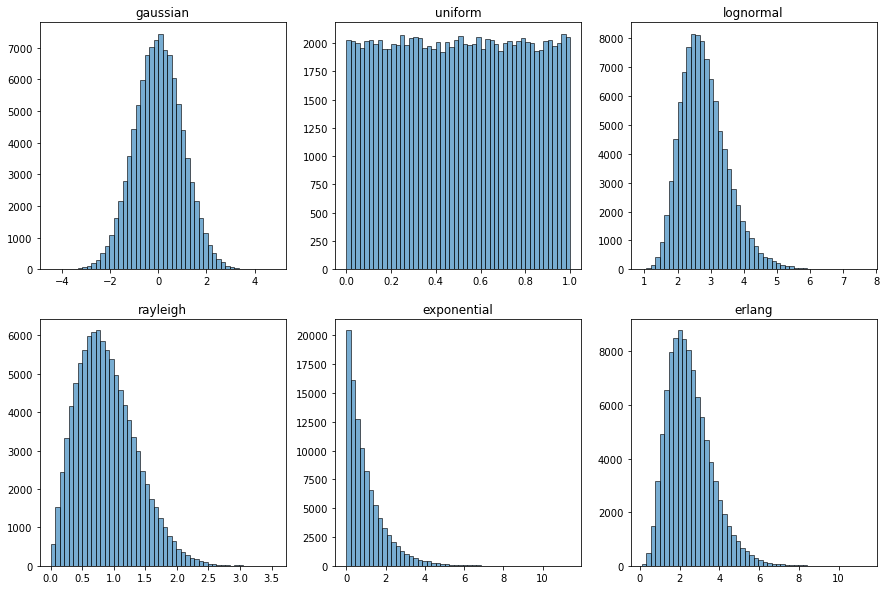

In [2]:
# Generating random noise using function imnoise
M = 100000
N = 1
img_for_noise = np.ones((M, N))

# define noise type list to cycle through
noise_type = ["gaussian", "uniform", "lognormal", "rayleigh", "exponential", "erlang"]

# plot histograms
fig_hist, ax_hist = plt.subplots(2, 3, figsize=(15,10))
ax_hist = ax_hist.ravel()

for idx, type in enumerate(noise_type):
    # Generate noise samples
    _, noise_samples = ec_img_utils.imnoise(img_for_noise, {"type": type})

    # compute histogram
    #hist, ctrs = skimage.exposure.histogram(noise_samples, nbins=50)

    # plot the histogram
    #ax_hist[idx].plot(ctrs, hist)
    ax_hist[idx].hist(noise_samples, bins=50, edgecolor='k', alpha=0.6)
    ax_hist[idx].set_title(type)